# SVM - Red Neuronal Densa

## SVM


In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv("embeddings_data.csv")

In [22]:
X = np.vstack([np.array(ast.literal_eval(vec), dtype=float) for vec in data["embedding_cls"]])
y = data["class"].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=611, shuffle = True)

In [24]:
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(kernel='linear',probability=True))
])

In [32]:
param_grid = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(pipeline_svc, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=2) 

In [33]:
grid_search.fit(X_train[:10000], y_train[:10000])
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [34]:
best_params = grid_search.best_params_

In [35]:
best_params

{'svc__C': 1, 'svc__kernel': 'rbf'}

In [36]:
best_score = grid_search.best_score_

In [37]:
best_score

0.8667997273632583

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4626
           1       0.91      0.83      0.86      4912

    accuracy                           0.87      9538
   macro avg       0.87      0.87      0.87      9538
weighted avg       0.87      0.87      0.87      9538



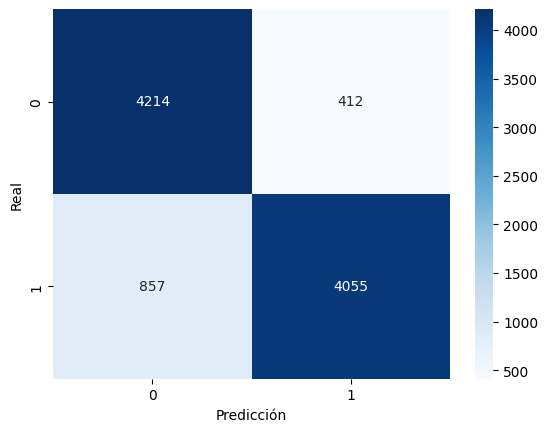

In [38]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

# Red Neuronal Densa

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

In [4]:
data = pd.read_csv("./embeddings_data.csv")

In [5]:
X = np.vstack([np.array(ast.literal_eval(vec), dtype=float) for vec in data["embedding_cls"]])
y = data["class"].values

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=31, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=31, stratify=y_temp)

In [11]:
def build_model(n_hidden_layers=1, n_neurons=128, input_dim=None):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    current_neurons = n_neurons
    for _ in range(n_hidden_layers):
        model.add(Dense(current_neurons, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(0.3))
        current_neurons = max(8, current_neurons // 2)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
param_grid = {
    "n_hidden_layers": [1, 2, 3],
    "n_neurons": [32, 64, 128]
}

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

best_params = None
best_score = 0
best_model = None
best_history = None

# Grid search manual 
for layers in param_grid["n_hidden_layers"]:
    for neurons in param_grid["n_neurons"]:
        fold_scores = []
        print(f"\n Evaluando: capas={layers}, neuronas={neurons}")
        
        for train_idx, val_idx in kfold.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            K.clear_session()
            model = build_model(n_hidden_layers=layers, n_neurons=neurons, input_dim=X.shape[1])
            history = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=10,
                                batch_size=32,
                                verbose=0)
            
            acc = history.history["val_accuracy"][-1]
            fold_scores.append(acc)
        
        mean_acc = np.mean(fold_scores)
        print(f"Promedio val_accuracy: {mean_acc:.4f}")
        
        if mean_acc > best_score:
            best_score = mean_acc
            best_params = (layers, neurons)

print(f"\n Mejor combinación: capas={best_params[0]}, neuronas={best_params[1]}")




 Evaluando: capas=1, neuronas=32
Promedio val_accuracy: 0.8556

 Evaluando: capas=1, neuronas=64
Promedio val_accuracy: 0.8564

 Evaluando: capas=1, neuronas=128
Promedio val_accuracy: 0.8550

 Evaluando: capas=2, neuronas=32
Promedio val_accuracy: 0.8601

 Evaluando: capas=2, neuronas=64
Promedio val_accuracy: 0.8549

 Evaluando: capas=2, neuronas=128


2025-05-18 23:52:46.579160: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 12 bytes spill stores, 12 bytes spill loads

2025-05-18 23:52:46.605705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 4 bytes spill stores, 4 bytes spill loads

2025-05-18 23:52:47.338984: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 4 bytes spill stores, 4 bytes spill loads

2025-05-18 23:52:47.371002: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 12 bytes spill stores, 12 bytes spill loads

2025-05-18 23:53:11.897934: I external/local_xla/xla

Promedio val_accuracy: 0.8554

 Evaluando: capas=3, neuronas=32
Promedio val_accuracy: 0.8567

 Evaluando: capas=3, neuronas=64
Promedio val_accuracy: 0.8510

 Evaluando: capas=3, neuronas=128
Promedio val_accuracy: 0.8554

 Mejor combinación: capas=2, neuronas=32


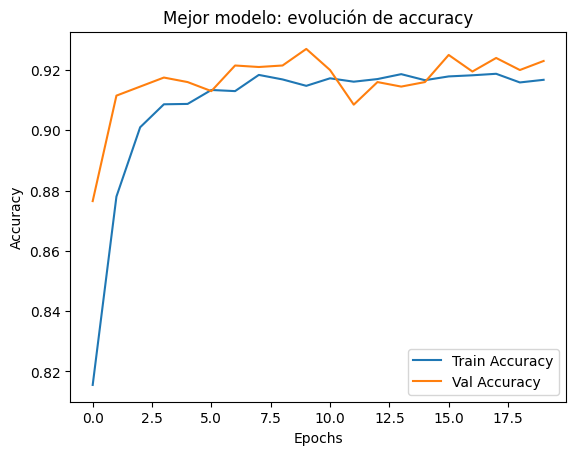

In [18]:
model = build_model(n_hidden_layers=best_params[0], n_neurons=best_params[1], input_dim=X.shape[1])
best_history = model.fit(X_train[:10000], y_train[:10000], validation_split=0.2, epochs=20, batch_size=32, verbose=0)
best_model = model


plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Mejor modelo: evolución de accuracy')
plt.show()


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      4669
           1       0.74      0.90      0.82      4869

    accuracy                           0.79      9538
   macro avg       0.81      0.79      0.79      9538
weighted avg       0.81      0.79      0.79      9538



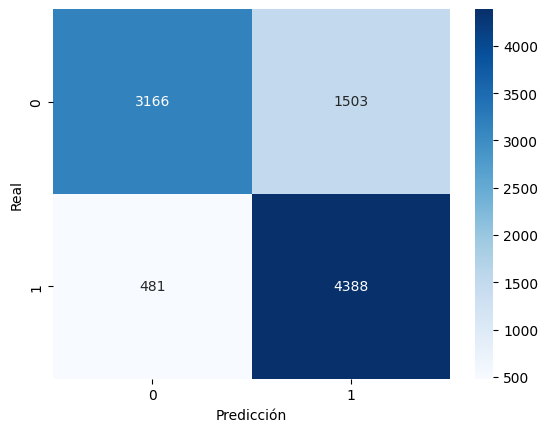

In [20]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()